In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import hashlib
import math, os
from tqdm import tqdm

In [33]:
pd.set_option('display.max_columns', 40)

In [34]:
# トレーニング用の入力データの選択
X_columns = ['locality', 'age', 'rank', 'leg', 'racing piont', \
             'S', 'B', 'Nige', 'Maki', 'Sashi', 'Ma', \
             '1st', '2nd', '3rd', 'Chakugai', 'win', '2ren', '3ren']


In [35]:
# Webスクレイピングで取得した戦績データをファイルから読み取り、データフレームに変換＋データ前処理
def get_df_train(places):
    
    init_flag = True
    for place in places:
        print('loading data for ' + place)
        filename = "data/" + place + "_train_data.csv"
        df_train = pd.read_csv(filename, encoding="SHIFT_JIS", header=0, nrows=None)

        targets = []
        name_ids = []
        localities = []

        for index, row in df_train.iterrows():

            # 結果をホットベクトル化
            result = row['result']
            if result == 1:
                target = 1
            else:
                target = 0
            targets.append(target)    

            # 名前をハッシュを使ってID化
            name = row['name']
            name_hash = hashlib.md5(name.encode()).hexdigest()
            name_id = name_hash[-8:]
            name_ids.append(name_id)

            # 　ランクの例外処理
            if row['rank'] == 'SS':
                df_train.loc[index, 'rank'] = '0'
            elif row['rank'] == 'L1':
                df_train.loc[index, 'rank'] = '6'

            # 出身地を地区毎にグループ化
            prefecture = row['prefecture']
            if prefecture in {'1', '2', '3', '5'}:
                locality = '1' #北東北
            elif prefecture in {'4', '6', '7'}:
                locality = '2' #南東北
            elif prefecture in {'8', '9'}:
                locality = '3' #茨栃
            elif prefecture in {'11', '13'}:
                locality = '4' #埼京
            elif prefecture in {'10', '15', '19', '20'}:
                locality = '5' #上信越
            elif prefecture in {'12', '14', '22'}:
                locality = '6' #南関東
            elif prefecture in {'16', '17', '21', '23', '24'}:
                locality = '7' #中部
            elif prefecture in {'18', '25', '26', '27', '28', '29', '30'}:
                locality = '8' #近畿
            elif prefecture in {'31', '32', '33', '34', '35'}:
                locality = '9' #中国
            elif prefecture in {'36', '37', '38', '39'}:
                locality = '10' #四国
            elif prefecture in {'40', '41', '42', '43', '44', '45', '46', '47'}:
                locality = '11' #九州
            else:
                locality = '12' #外国

            localities.append(locality)

        # 前処理したデータのデータフレームへの置き換え
        df_train['target'] = targets
        df_train['name_id'] = name_ids
        df_train['locality'] = localities

        # カラムの順番入れ替え（見やすさのため）
        columns = list(df_train.columns)
        columns.remove('name_id')
        columns.insert(columns.index("name") + 1, "name_id")
        columns.remove('locality')
        columns.insert(columns.index("prefecture") + 1, "locality")

        df_train = df_train.loc[:,columns]
        
        if init_flag:
            df_train_concat = df_train
            init_flag = False
        else:
            df_train_concat = pd.concat([df_train_concat, df_train])
    
    return df_train_concat

In [36]:
def get_train_test_data(df_train):
    X = []
    target = []
        
    # 各レース毎に
    grouped = df_train.groupby(['date', 'place', 'race_num'])
    for race_name, group in tqdm(grouped):
        #print(race_name)
        racer_count = group.shape[0]
        # もし、９輪ではないレースは、トレーニングの対象から外す（モデルを固めるため）
        if racer_count != 9:
            continue
        X.append(group[X_columns].values)
        target.append(group['target'].values)

    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    d_ = np.array(target)

    X_train, X_test, d_train, d_test = train_test_split(X, d_, test_size = 0.2)

    return X_train, X_test, d_train, d_test


In [37]:
places = []
for filename in os.listdir('data/'):
    place = filename.split('_')[0]
    places.append(place)
print(places)

['aomori', 'chiba', 'hakodate', 'hiratsuka', 'ito', 'iwakitaira', 'kawasaki', 'keiokaku', 'maebashi', 'matsudo', 'odawara', 'omiya', 'seibuen', 'shizuoka', 'tachikawa', 'toride', 'utsunomiya', 'yahiko']


In [38]:
places = ['kawasaki', 'hiratsuka']

print("Loading Training Data...")
df_train = get_df_train(places)

Loading Training Data...
loading data for kawasaki


c:\users\ttsuchiy\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2901: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for hiratsuka


In [39]:
class DNN(object):
    def __init__(self, n_in, n_hiddens, n_out):
        self.n_in = n_in
        self.n_hiddens = n_hiddens
        self.n_out = n_out
        self.weights = []
        self.biases = []

        self._x = None
        self._y = None
        self._t = None,
        self._keep_prob = None
        self._sess = None
        self._history = {
            'accuracy': [],
            'loss': []
        }

    def weight_variable(self, shape):
        # He 初期化
        n_sum = 1
        for n in shape:
            n_sum *= n
        stddev = math.sqrt(2.0 / n_sum)
        print('stddev: ', stddev)
        initial = tf.truncated_normal(shape, stddev=stddev)
        return tf.Variable(initial)

    def bias_variable(self, shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial)

    def inference(self, x, keep_prob):
        # 入力層 - 隠れ層、隠れ層 - 隠れ層
        for i, n_hidden in enumerate(self.n_hiddens):
            if i == 0:
                input = x
                input_dim = self.n_in
            else:
                input = output
                input_dim = self.n_hiddens[i-1]

            self.weights.append(self.weight_variable([input_dim, n_hidden]))
            self.biases.append(self.bias_variable([n_hidden]))

            h = tf.nn.relu(tf.matmul(input, self.weights[-1]) + self.biases[-1])
            output = tf.nn.dropout(h, keep_prob)

        # 隠れ層 - 出力層
        self.weights.append(self.weight_variable([self.n_hiddens[-1], self.n_out]))
        self.biases.append(self.bias_variable([self.n_out]))

        y = tf.nn.softmax(tf.matmul(output, self.weights[-1]) + self.biases[-1])
        
        return y

    def loss(self, y, t):
        # クロスエントロピー
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y), axis=1))
        # L2 正則化
        l2_decay = 0.0001
        l2_losses = [tf.nn.l2_loss(w) for w in self.weights]
        l2_loss = l2_decay * tf.add_n(l2_losses)
        loss = cross_entropy + l2_loss
        return loss

    def training(self, loss):
        optimizer = tf.train.AdamOptimizer()
        train_step = optimizer.minimize(loss)
        return train_step

    def accuracy(self, y, t):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy

    def fit(self, X_train, Y_train, nb_epoch=100, batch_size=100, p_keep=0.5, verbose=1):
        x = tf.placeholder(tf.float32, shape=[None, self.n_in])
        t = tf.placeholder(tf.float32, shape=[None, self.n_out])
        keep_prob = tf.placeholder(tf.float32)

        self._x = x
        self._t = t
        self._keep_prob = keep_prob

        y = self.inference(x, keep_prob)
        loss = self.loss(y, t)
        train_step = self.training(loss)
        accuracy = self.accuracy(y, t)

        init = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init)

        self._y = y
        self._sess = sess

        N_train = len(X_train)
        n_batches = N_train // batch_size

        for epoch in range(nb_epoch):
            X_, Y_ = shuffle(X_train, Y_train)

            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size

                sess.run(train_step, feed_dict={
                    x: X_[start:end],
                    t: Y_[start:end],
                    keep_prob: p_keep
                })
            loss_ = loss.eval(session=sess, feed_dict={
                x: X_train,
                t: Y_train,
                keep_prob: 1.0
            })
            accuracy_ = accuracy.eval(session=sess, feed_dict={
                x: X_train,
                t: Y_train,
                keep_prob: 1.0
            })
            self._history['loss'].append(loss_)
            self._history['accuracy'].append(accuracy_)

            if verbose:
                print('epoch:', epoch,
                      ' loss:', loss_,
                      ' accuracy:', accuracy_)

        return self._history

    def evaluate(self, X_test, Y_test):
        accuracy = self.accuracy(self._y, self._t)
        return accuracy.eval(session=self._sess, feed_dict={
            self._x: X_test,
            self._t: Y_test,
            self._keep_prob: 1.0
        })

In [40]:
print("Generating Training/Test Data")
X_train, X_test, Y_train, Y_test = get_train_test_data(df_train)


model = DNN(n_in = len(X_train[1]), n_hiddens=[512], n_out=9)

history = model.fit(X_train, Y_train, nb_epoch = 300, batch_size=32, p_keep=0.5)

accuracy = model.evaluate(X_test, Y_test)
print('accuracy: ', accuracy)


Generating Training/Test Data


100%|█████████████████████████████████████| 7370/7370 [00:07<00:00, 950.23it/s]


stddev:  0.004910463758239913
stddev:  0.020833333333333332
epoch: 0  loss: 1.9588829  accuracy: 0.27259186
epoch: 1  loss: 1.9504446  accuracy: 0.30933467
epoch: 2  loss: 1.9193548  accuracy: 0.28326714
epoch: 3  loss: 1.9044218  accuracy: 0.30958292
epoch: 4  loss: 1.8976045  accuracy: 0.31305858
epoch: 5  loss: 1.8978404  accuracy: 0.32919562
epoch: 6  loss: 1.9098091  accuracy: 0.32174778
epoch: 7  loss: 1.9041033  accuracy: 0.32497516
epoch: 8  loss: 1.9111382  accuracy: 0.31653425
epoch: 9  loss: 1.8796667  accuracy: 0.32571995
epoch: 10  loss: 1.9242587  accuracy: 0.30561072
epoch: 11  loss: 1.888956  accuracy: 0.33440915
epoch: 12  loss: 1.9093066  accuracy: 0.30734855
epoch: 13  loss: 1.8927796  accuracy: 0.32423037
epoch: 14  loss: 1.8899994  accuracy: 0.32199603
epoch: 15  loss: 1.8974435  accuracy: 0.30958292
epoch: 16  loss: 1.8662931  accuracy: 0.3306852
epoch: 17  loss: 1.8753008  accuracy: 0.31603774
epoch: 18  loss: 1.912779  accuracy: 0.316286
epoch: 19  loss: 1.87087

epoch: 166  loss: 1.694603  accuracy: 0.37562066
epoch: 167  loss: 1.7217163  accuracy: 0.36916584
epoch: 168  loss: 1.7162269  accuracy: 0.37462762
epoch: 169  loss: 1.7018117  accuracy: 0.37313804
epoch: 170  loss: 1.723131  accuracy: 0.3785998
epoch: 171  loss: 1.716079  accuracy: 0.3785998
epoch: 172  loss: 1.7230312  accuracy: 0.377855
epoch: 173  loss: 1.7112857  accuracy: 0.37884808
epoch: 174  loss: 1.7209193  accuracy: 0.38480636
epoch: 175  loss: 1.752122  accuracy: 0.36171797
epoch: 176  loss: 1.7374487  accuracy: 0.37537238
epoch: 177  loss: 1.7113328  accuracy: 0.37437934
epoch: 178  loss: 1.7160957  accuracy: 0.38455808
epoch: 179  loss: 1.7438133  accuracy: 0.35476664
epoch: 180  loss: 1.7350156  accuracy: 0.36146972
epoch: 181  loss: 1.7401284  accuracy: 0.37164846
epoch: 182  loss: 1.7169421  accuracy: 0.36544192
epoch: 183  loss: 1.6843542  accuracy: 0.38207546
epoch: 184  loss: 1.7394558  accuracy: 0.37413108
epoch: 185  loss: 1.698438  accuracy: 0.38530287
epoch: 18

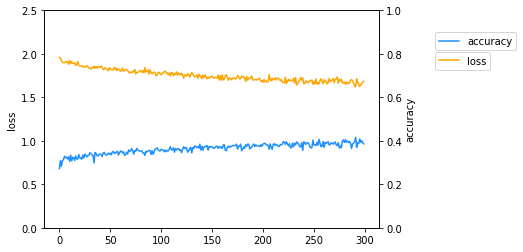

In [41]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # 2つのプロットを関連付ける

ax1.plot(history['loss'], label='loss', color='orange')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 2.5)
ax1.legend(loc='best', bbox_to_anchor=(1.01, 0.71, 0.322, .100), borderaxespad=0.,)

ax2.plot(history['accuracy'], label='accuracy', color='dodgerblue')
ax2.set_ylabel('accuracy')
ax2.set_ylim(0, 1.0)
ax2.legend(loc='best', bbox_to_anchor=(1.01, 0.8, 0.4, .100), borderaxespad=0.,)

plt.show()